<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/NLP_pipeline_b%C3%A1sico_clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto con Naive Bayes, Regresión Logística y SVM

Este notebook muestra un pipeline de clasificación de texto básico utilizando métodos tradicionales de ML: Naive Bayes, Regresión Logística y Support Vector Machine (SVM). El conjunto de datos les "Economic news article tone and relevance" que contiene aproximadamente 8000 artículos de noticias etiquetados como relevantes o no relevantes para la economía de EE. UU.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# Las importaciones de matplotlib se usan para graficar las matrices de confusión de los clasificadores
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# importar métodos de extracción de características desde sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # Corrected import

# preprocesamiento del texto
import string
import re

# importar clasificadores desde sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

# importar diferentes métricas para evaluar los clasificadores
from sklearn.metrics import accuracy_score

# importar train_test_split desde sklearn.model_selection
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# importar la función time del módulo time para medir la duración del entrenamiento
from time import time

### Carga de datos

In [2]:
our_data = pd.read_csv("https://raw.githubusercontent.com/gustavovazquez/datasets/refs/heads/main/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

In [3]:
display(our_data.shape) # Número de instancias (filas)
instances = our_data.shape[0]
display(our_data.head()) # Primeras 5 instancias
# Proporción de las etiquetas (yes/no/not sure)
our_data["relevance"].value_counts()/instances # Distribución de clases (en porcentaje) del dataset

(8000, 15)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


,count
relevance,
no,0.821375
yes,0.177500
not sure,0.001125


Existe un desbalance en los datos, ya que el 82% de los artículos están etiquetados como no relevantes. Es decir, la mayoría de los artículos no son relevantes para la economía de EE. UU. (pues las noticias cubren una gran variedad de temas). Debemos tener en cuenta este desequilibrio de clases al interpretar el desempeño del clasificador.

A continuación, vamos a convertir las etiquetas de clase en una variable binaria, para mayor comodidad:

- 1 para yes,

- 0 para no,

e ignoraremos la clase Not sure.

In [4]:
# convertir las etiquetas en enteros 0 y 1
our_data = our_data[our_data.relevance != "not sure"] # borramos los relevance="not sure".
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # yes -> 1, no -> 0.
our_data = our_data[["text","relevance"]] # Extraemos las columnas que nos interesan: text y relevance
display(our_data.shape)
our_data.head()

(7991, 2)

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


### Pre-procesamiento

Los pasos típicos incluyen tokenización, conversión a minúsculas, eliminación de palabras vacías, signos de puntuación, etc., y vectorización. También pueden aplicarse otros procesos como el stemming o la lematización.

En este caso realizamos eliminación de etiquetas <br> (line break), puntuación, números y palabras vacías.

Aunque en este ejemplo utilizamos la lista de stopwords provista por sklearn, existen muchas otras listas disponibles (por ejemplo, las de NLTK) o incluso pueden utilizarse listas personalizadas de stopwords, según las necesidades de la tarea.









Ask ChatGPT


In [5]:
stopwords = ENGLISH_STOP_WORDS
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

### Construccion del modelo

- Dividir los datos en conjuntos de entrenamiento y prueba (75% para entrenamiento, 25% para prueba). Tener en cuenta el data leakage

- Extraer feature del conjunto de entrenamiento utilizando CountVectorizer que implementa la técnica de Bag of Words. Usaremos la función clean de preprocesamiento junto con el vectorizador.

- Transformar los datos de prueba para que tengan el mismo vector de características que los datos de entrenamiento.

- Entrenar el clasificador.

- Evaluar el rendimiento.

In [6]:
import sklearn
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # X
y = our_data.relevance # y
print(X.shape, y.shape)
# separamos en 75 / 25
random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [7]:
vect = CountVectorizer(preprocessor=clean) # instanciamos el vectorizador (se aplica clean en forma previa)
X_train_dtm = vect.fit_transform(X_train) # generamos el BoW aplicando sobre los datos de entrenamiento
X_test_dtm = vect.transform(X_test) # !!!! observar que aplicamos las transformación "aprendida" a X_test para evitar data leakage
print(X_train_dtm.shape, X_test_dtm.shape)
# observar las dimensiones!

(5993, 49773) (1998, 49773)


In [8]:
#Entrenamiento y predicción
nb = MultinomialNB() # instanciar modelo Multinomial Naive Bayes
%time nb.fit(X_train_dtm, y_train) # IPython "magic command"
y_pred_class = nb.predict(X_test_dtm) # predicción

CPU times: user 14.9 ms, sys: 933 µs, total: 15.8 ms
Wall time: 24.3 ms


Accuracy:  0.7717717717717718
ROC_AOC_Score:  0.7318614929710678


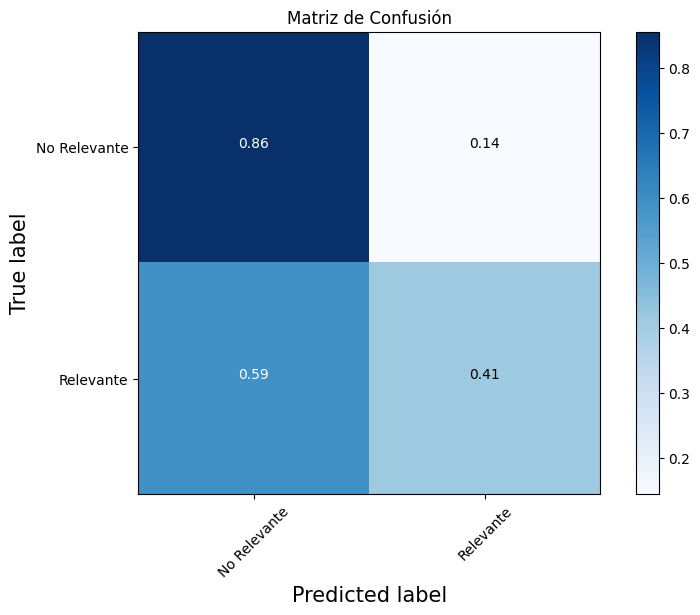

In [9]:
# Evaluación

# Function to plot confusion matrix.
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


# Accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))


# Matriz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['No Relevante','Relevante'],normalize=True,
                      title='Matriz de Confusión')

# Area under the curve(AUC)
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

Podemos notar que el clasificador tiene mal desempeño al identificar artículos relevantes, mientras que funciona bien con los no relevantes.

El vector de características es muy grande, lo que podría estar generando mucho ruido en forma de características que aparecen muy rara vez y que no aportan valor al aprendizaje.

Podemos modificar el CountVectorizer para que utilice un número máximo de características.

CPU times: user 8.46 ms, sys: 23 µs, total: 8.49 ms
Wall time: 8.5 ms
Accuracy:  0.6896896896896897


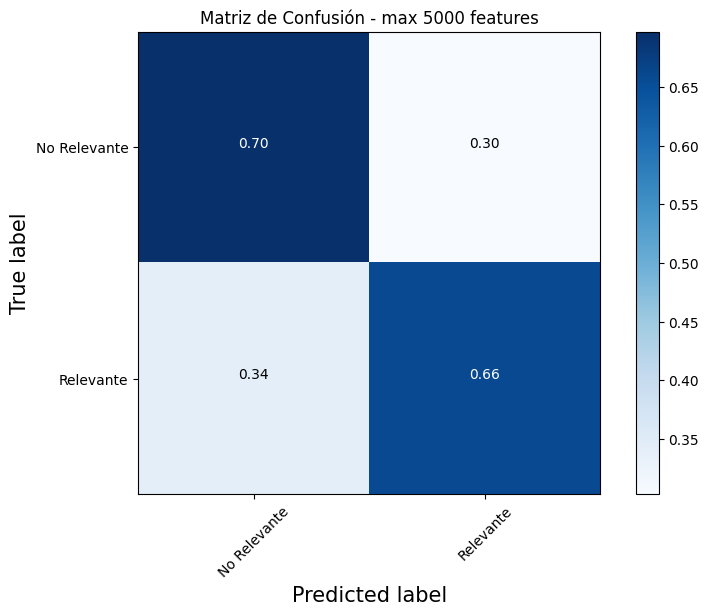

In [10]:
vect = CountVectorizer(preprocessor=clean, max_features=5000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['No Relevante','Relevante'],normalize=True,
                      title='Matriz de Confusión - max 5000 features')

El rendimiento en la clase "Relevante" ha mejorado, aunque la precisión general haya disminuido un 10%.

Probamos regresión logística y definimos class_weight como "balanced" para contemplar el problema de imbalance de clases de este conjunto de datos.

Accuracy:  0.7322322322322322
AUC:  0.7318614929710678


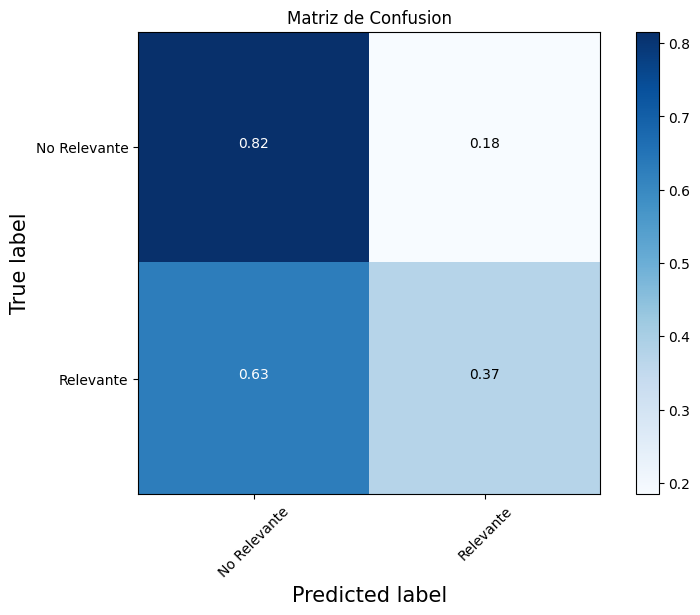

In [11]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train_dtm, y_train)

y_pred_class = logreg.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['No Relevante','Relevante'],normalize=True,
                      title='Matriz de Confusion')

Probando con LinearSVC, y reduciendo la cantidad de features a 1000.

Accuracy:  0.7697697697697697
AUC:  0.7318614929710678


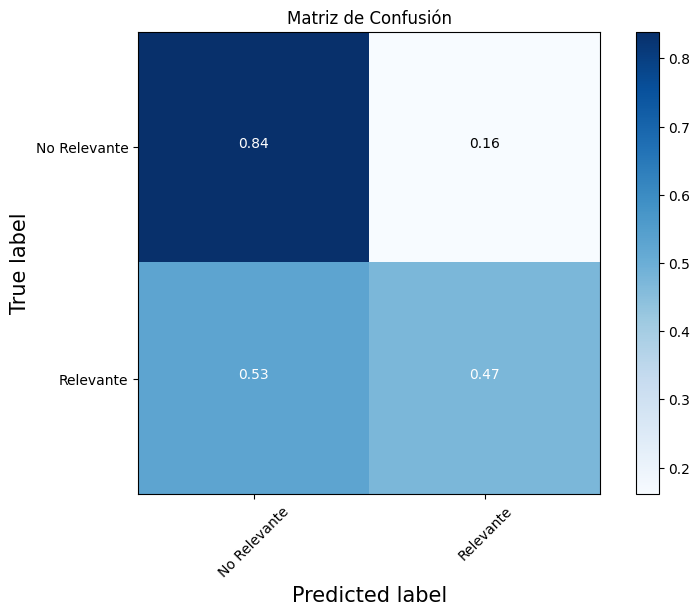

In [12]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#classifier = LinearSVC(class_weight='balanced')
classifier =SVC(kernel='rbf', class_weight='balanced') # (que sucede con un clasificador no lineal?)
classifier.fit(X_train_dtm, y_train)

y_pred_class = classifier.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['No Relevante','Relevante'],normalize=True,
                      title='Matriz de Confusión')

Si nos guiamos únicamente por la precisión global, deberíamos elegir el primer clasificador. Sin embargo este modelo muestra un bajo desempeño al identificar los artículos relevantes (que son los de nuestro interés).

Si priorizamos el rendimiento sobre la clase “Relevante”, entonces el segundo clasificador sería más adecuado. Por lo tanto, la elección del mejor modelo depende del objetivo específico del caso de uso. Lo que se considera “mejor” debe estar alineado con lo que realmente queremos optimizar.